In [1]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
from sklearn.decomposition import PCA
import umap
import xarray as xr


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# keywargs for annotating panels
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


In [3]:
# helpful functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount


# Read in data

In [4]:
# read in sample metadata

filepath_sample_metadata = '../../data/metadata/sample_metadata.csv'
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df['samplename'] = [name[:-2] for name in sample_df['SampleID']]
sample_df = sample_df.rename(columns={'SampleID': 'sample', 'Replicate': 'replicate'})

sample_df


,sample,Cruise,Dataset,Experiment,Station,Cast,Datetime,Latitude,Longitude,Depth,replicate,SmallFraction,LargeFraction,Unfractionated,samplename
0,G3.DEPTH.NS.S6C7.130m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:36,32.92,-158.0,130,B,G3.DEPTH.NS.S6C7.130m.0_2um.B,NaN,True,G3.DEPTH.NS.S6C7.130m
1,G3.DEPTH.NS.S6C7.75m.A,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:40,32.92,-158.0,75,A,G3.DEPTH.NS.S6C7.75m.0_2um.A,NaN,True,G3.DEPTH.NS.S6C7.75m
2,G3.DEPTH.NS.S6C7.75m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:40,32.92,-158.0,75,B,G3.DEPTH.NS.S6C7.75m.0_2um.B,NaN,True,G3.DEPTH.NS.S6C7.75m
3,G3.DEPTH.NS.S6C7.15m.A,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:44,32.92,-158.0,15,A,G3.DEPTH.NS.S6C7.15m.0_2um.A,NaN,True,G3.DEPTH.NS.S6C7.15m
4,G3.DEPTH.NS.S6C7.15m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:44,32.92,-158.0,15,B,G3.DEPTH.NS.S6C7.15m.0_2um.B,NaN,True,G3.DEPTH.NS.S6C7.15m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,G2.REXP3.NS.LoNP.T96.A,G2,Resource ratio incubation,REXP3 T96 LoNP A,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,A,G2.REXP3.NS.LoNP.T96.0_2um.A,G2.REXP3.NS.LoNP.T96.3um.A,False,G2.REXP3.NS.LoNP.T96
218,G2.REXP3.NS.LoNP.T96.C,G2,Resource ratio incubation,REXP3 T96 LoNP C,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,C,G2.REXP3.NS.LoNP.T96.0_2um.C,G2.REXP3.NS.LoNP.T96.3um.C,False,G2.REXP3.NS.LoNP.T96
219,G2.REXP3.NS.NPFe.T96.A,G2,Resource ratio incubation,REXP3 T96 NPFe A,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,A,G2.REXP3.NS.NPFe.T96.0_2um.A,G2.REXP3.NS.NPFe.T96.3um.A,False,G2.REXP3.NS.NPFe.T96
220,G2.REXP3.NS.NPFe.T96.B,G2,Resource ratio incubation,REXP3 T96 NPFe B,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,B,G2.REXP3.NS.NPFe.T96.0_2um.B,G2.REXP3.NS.NPFe.T96.3um.B,False,G2.REXP3.NS.NPFe.T96


In [5]:
# read in normalized data

syn_ds = xr.open_dataset('../../data/3-normalization/syn-tensor-dataset.nc')
pro_ds = xr.open_dataset('../../data/3-normalization/pro-tensor-dataset.nc')

syn_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6578, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040245 60040289
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...

# Pre-normalization mean-variance relationship

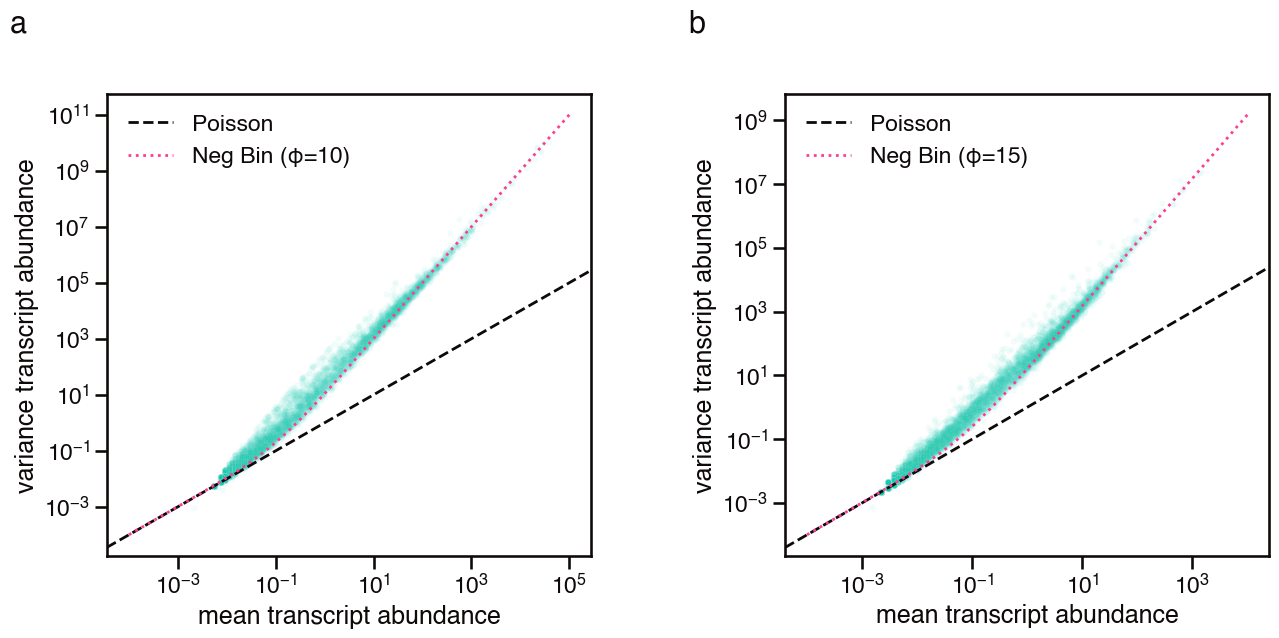

In [13]:
# make figure showing mean-variance relationship of pro and syn data

fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'wspace': .4})


# pull out prochlorococcus read abundance data (pre-normalization)
pro_abun_df = pro_ds.readcount.to_dataframe().reset_index()
pro_abun_df = pro_abun_df.pivot(index='ortholog', columns=['sample', 'clade'], values='readcount')
# set negative binomial parameters
phi = 10
xx = np.logspace(-4, 5, num=248)
yy = xx + phi * np.power(xx, 2)
# plot mean vs. variance scatterplot
sns.scatterplot(
    x=pro_abun_df.mean(axis=1), 
    y=pro_abun_df.var(axis=1), 
    alpha=0.05, 
    s=20, 
    edgecolors=None, 
    color=sns.color_palette()[2], 
    legend=False, 
    ax=axes[0]
)
# plot poisson reference line
axes[0].axline((0, 0), slope=1, linestyle='--', color=sns.color_palette()[4], label='Poisson');
# plot negative binomial reference line
axes[0].plot(xx, yy, linestyle=':', color=sns.color_palette()[3], label='Neg Bin (φ={})'.format(phi));
# set figure parameters and labels
axes[0].annotate('a', xy=(-0.2, 1.15), **annot_kwgs)
axes[0].set(xscale='log', yscale='log', xlabel='mean transcript abundance', ylabel='variance transcript abundance')
axes[0].legend()


# pull out synechococcus read abundance data (pre-normalization)
syn_abun_df = syn_ds.readcount.to_dataframe().reset_index()
syn_abun_df = syn_abun_df.pivot(index='ortholog', columns=['sample', 'clade'], values='readcount')
# set negative binomial parameters
phi = 15
xx = np.logspace(-4, 4, num=248)
yy = xx + phi * np.power(xx, 2)
# plot mean vs. variance scatterplot
sns.scatterplot(
    x=syn_abun_df.mean(axis=1), 
    y=syn_abun_df.var(axis=1), 
    alpha=0.05, 
    s=20, 
    edgecolors=None, 
    color=sns.color_palette()[2], 
    legend=False, 
    ax=axes[1]
)
# plot poisson reference line
axes[1].axline((0, 0), slope=1, linestyle='--', color=sns.color_palette()[4], label='Poisson');
# plot negative binomial reference line
axes[1].plot(xx, yy, linestyle=':', color=sns.color_palette()[3], label='Neg Bin (φ={})'.format(phi));
# set figure parameters and labels
axes[1].annotate('b', xy=(-0.2, 1.15), **annot_kwgs)
axes[1].set(xscale='log', yscale='log', xlabel='mean transcript abundance', ylabel='variance transcript abundance')
axes[1].legend()

plt.savefig('prenorm-var-v-mean.png', bbox_inches='tight')


# Post-normalization mean-variance relationship

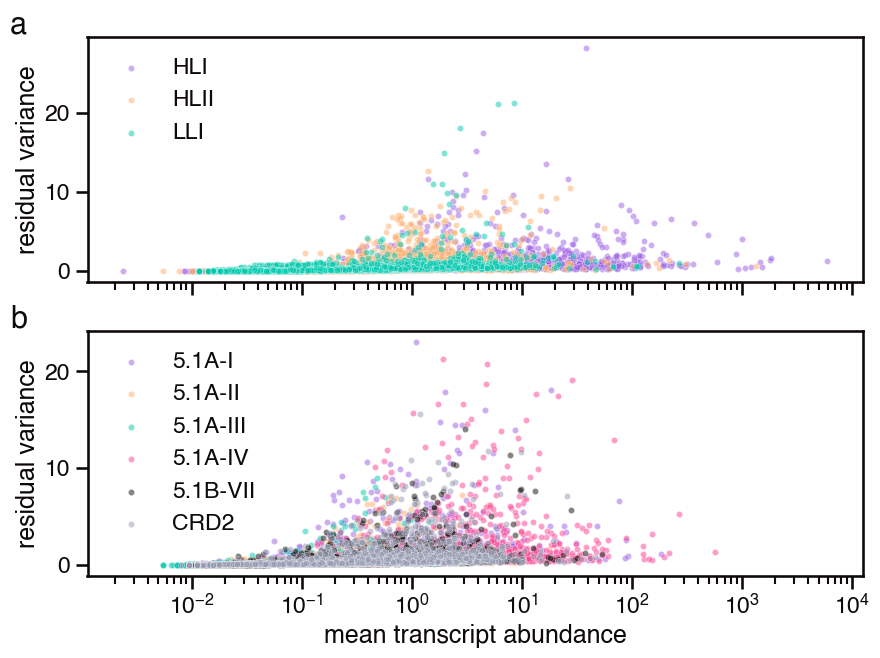

In [22]:
# figure showing post-normalization mean-variance relationship
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# prochlorococcus
ds = pro_ds
# iterate through clades
for i, clade in enumerate(ds.clade.data):
    abundance = ds.sel(clade=clade).readcount.to_pandas()
    residual = ds.sel(clade=clade).residual.to_pandas()
    sns.scatterplot(
        x=abundance.apply(geometric_mean, axis=1), 
        y=residual.var(axis=1), 
        alpha=0.5, 
        s=20, 
        edgecolors=None, 
        color=sns.color_palette()[i], 
        label=clade, 
        legend=False, 
        ax=axes[0]
    )
# set figure parameters and labels
axes[0].annotate('a', xy=(-0.1, 1.05), **annot_kwgs)
axes[0].set(xscale='log', ylabel='residual variance')
axes[0].legend(loc='upper left')


# synechococcus
ds = syn_ds
# iterate through clades
for i, clade in enumerate(ds.clade.data):
    abundance = ds.sel(clade=clade).readcount.to_pandas()
    residual = ds.sel(clade=clade).residual.to_pandas()
    # fix 'Costa Rica Dome (CRD)' typo
    if clade == 'CDR2':
        clade = 'CRD2'
    sns.scatterplot(
        x=abundance.apply(geometric_mean, axis=1), 
        y=residual.var(axis=1), 
        alpha=0.5, 
        s=20, 
        edgecolors=None, 
        color=sns.color_palette()[i], 
        label=clade, 
        legend=False, 
        ax=axes[1]
    )
# set figure parameters and labels
axes[1].annotate('b', xy=(-0.1, 1.05), **annot_kwgs)
axes[1].set(xscale='log', xlabel='mean transcript abundance', ylabel='residual variance')
axes[1].legend(loc='upper left')

plt.savefig('postnorm-var-v-mean.png', bbox_inches='tight')


# Post-normalization UMAP analysis

In [155]:
# make dataframes from data tensors

# unfold syn residuals into dataframe
syn_df = syn_ds.residual.to_dataframe().reset_index().pivot(
    index='sample', 
    columns=['ortholog', 'clade']
)

# unfold pro residuals into dataframe
pro_df = pro_ds.residual.to_dataframe().reset_index().pivot(
    index='sample', 
    columns=['ortholog', 'clade']
)

residual_dfs = {
    'pro': pro_df, 
    'syn': syn_df
}


In [156]:
# UMAP of PCA

# parameters
n_comp_pca = 20
n_comp_umap = 2
seed = 9481 + 4

reduced_dfs = {}

# run dimensionality reduction for each dataset
for genus in ['pro', 'syn']:
    print('\n{}'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus]))
    input_df = residual_dfs[genus]
    
    # run PCA
    print('\tRunning PCA with {} components...'.format(n_comp_pca))
    pca_model = PCA(n_components=n_comp_pca, random_state=seed)
    embedding = pca_model.fit_transform(input_df)

    # run UMAP
    print('\tRunning UMAP with {} components...'.format(n_comp_umap))
    umap_model = umap.UMAP(n_components=n_comp_umap, random_state=seed)
    # embedding = umap_model.fit_transform(input_df)
    embedding = umap_model.fit_transform(embedding)

    # merge on metadata
    embedding_df = pd.DataFrame(embedding, index=input_df.index)
    merged_df = pd.merge(embedding_df.reset_index(), sample_df, on='sample', how='left')
    
    # save to dictionary
    reduced_dfs[genus] = merged_df



Prochlorococcus
	Running PCA with 20 components...
	Running UMAP with 2 components...

Synechococcus
	Running PCA with 20 components...
	Running UMAP with 2 components...



Prochlorococcus



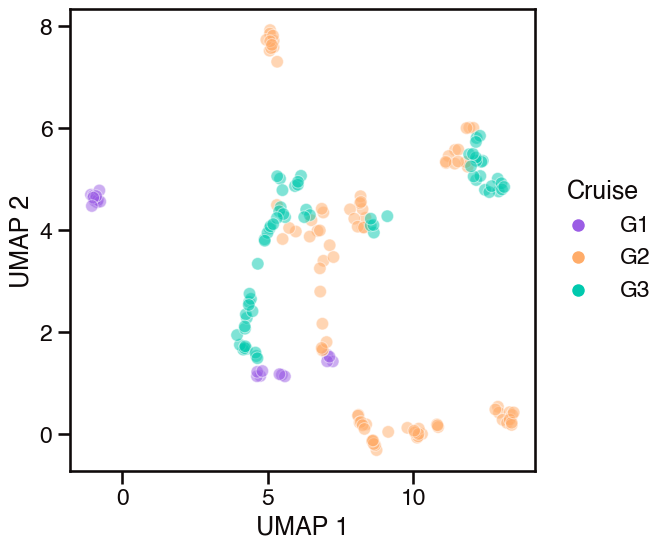

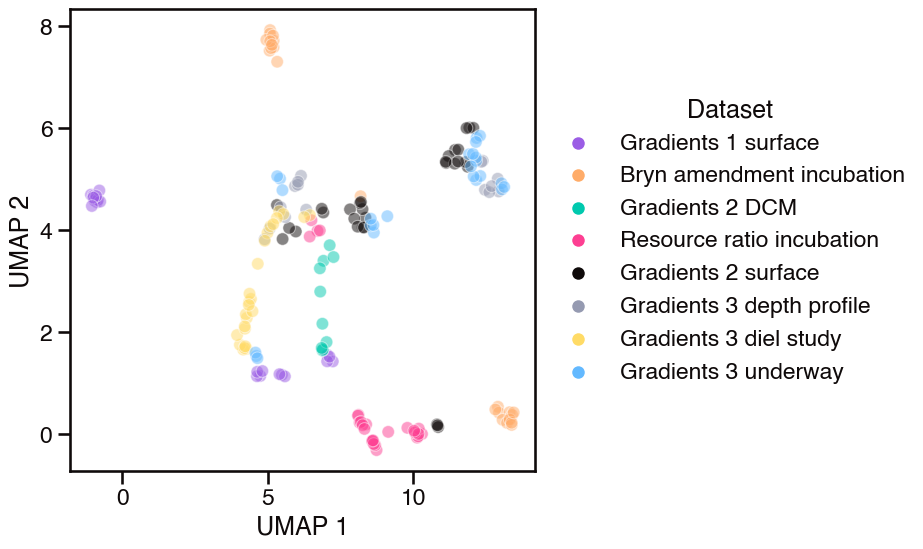

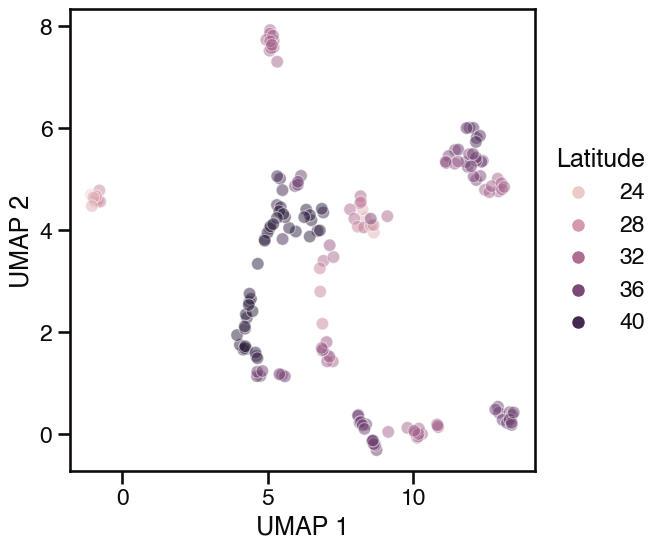

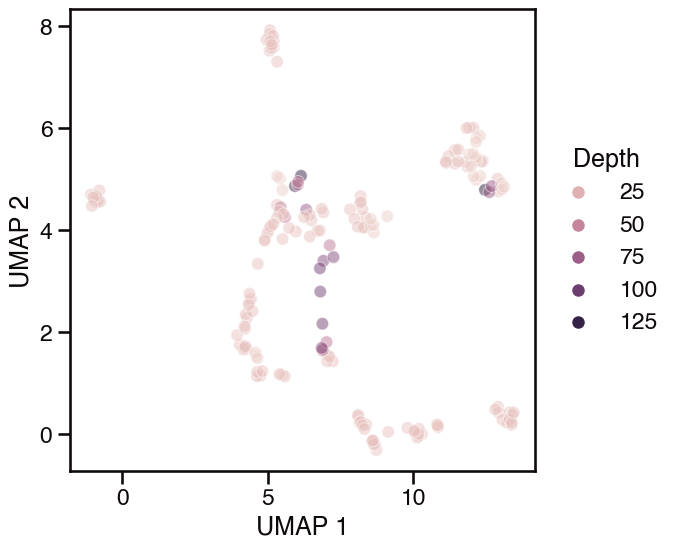

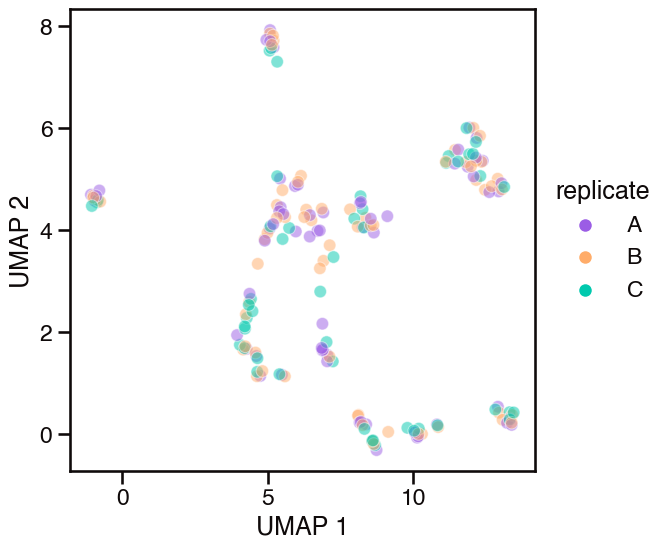


Synechococcus



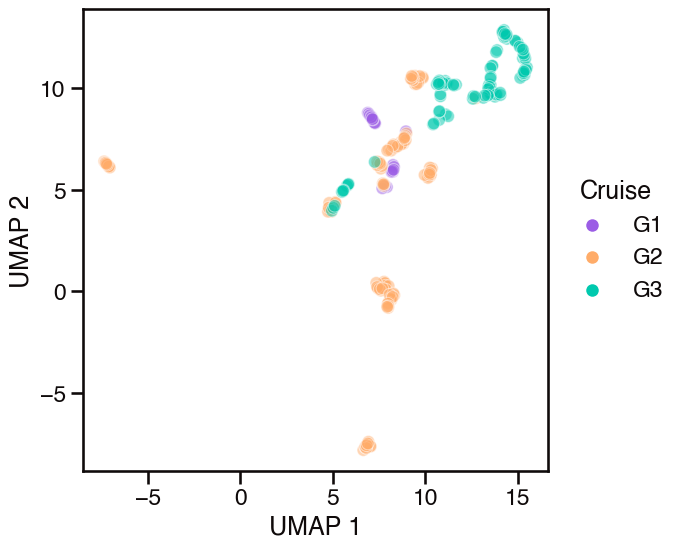

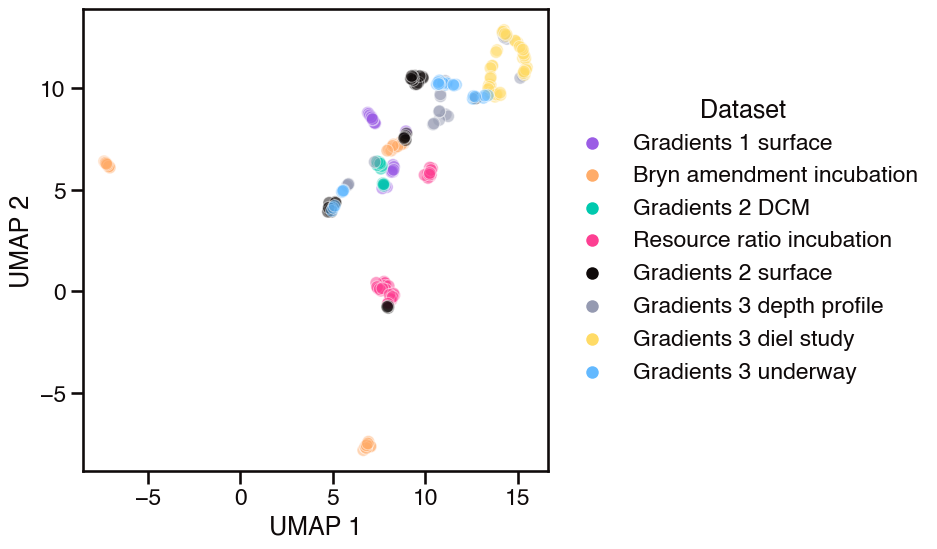

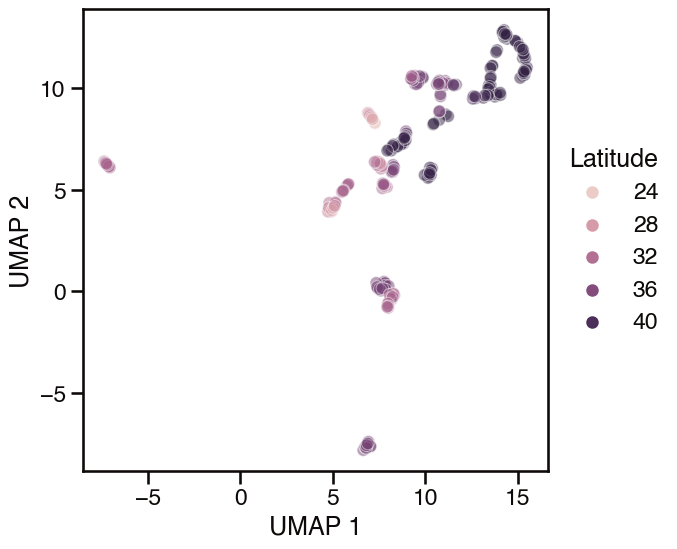

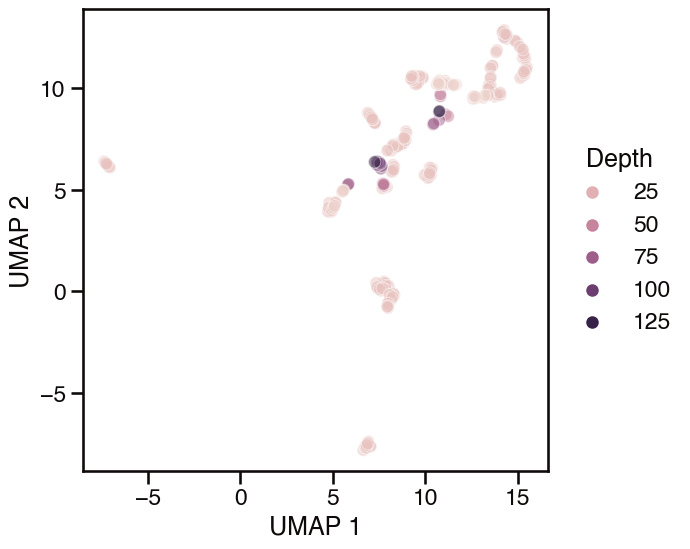

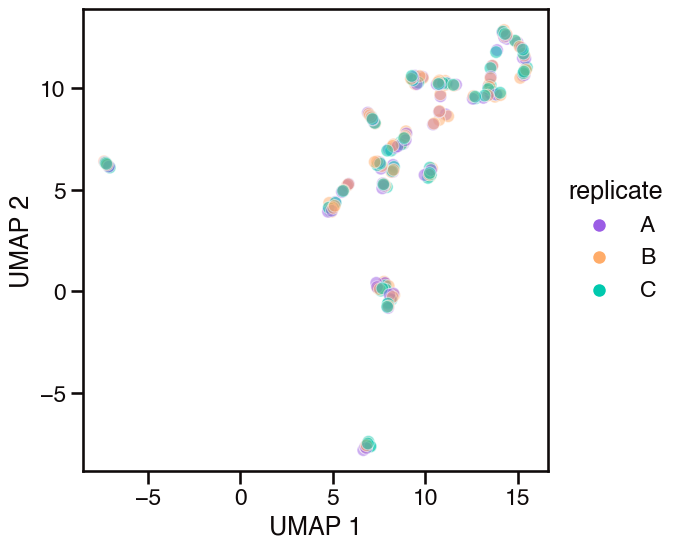

In [157]:
# plot dimensionality-reduced data

# variables = ['Cruise', 'Dataset', 'Latitude', 'Depth', 'replicate', 'Unfractionated']
variables = ['Cruise', 'Dataset', 'Latitude', 'Depth', 'replicate']

# plot both datasets
for genus in ['pro', 'syn']:
    print('\n{}\n'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus]))
    plot_df = reduced_dfs[genus]
    
    # plot each variable
    for var in variables:
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.scatterplot(x=0, y=1, hue=var, alpha=0.5, data=plot_df, ax=ax)
        plt.legend(title=var, loc='center left', bbox_to_anchor=[1, 0.5]);
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
#         plt.savefig('{}-residuals-umap-{}.png'.format(genus, var), bbox_inches='tight')
        plt.show()
